In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.backends.cudnn as cudnn
cudnn.benchmark = True  # fire on all cylinders

In [ ]:
train_data = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 337352920.25it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 20098837.54it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 184364773.85it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 10432929.23it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
print(len(train_data), len(test_data))

60000 10000


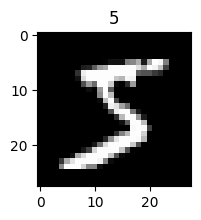

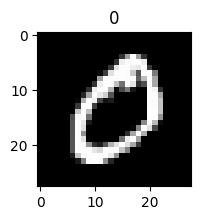

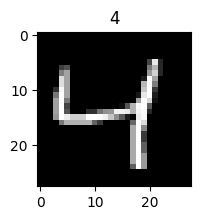

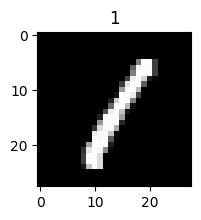

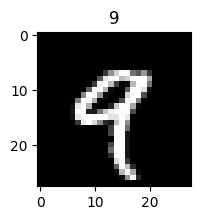

In [ ]:
for i in range(5):
    plt.figure(figsize=(2, 2))
    plt.imshow(train_data[i][0].permute(1,2,0).repeat(1,1,3).numpy()) # Mnist image size - 1 * 28 * 28
    plt.title(train_data[i][1])
    plt.show()

**2. White Box Evasion Attack - Task 1**

In [ ]:
class MNISTModel(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        """
        :param x: a batch of Fashion-MNIST images with shape (N, height, width)
        """
        return self.main(x.view(x.shape[0], -1))

In [ ]:
model = MNISTModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Set the model to train mode
model.train()

for epoch in range(5):
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
    for images, labels in train_loader:
        optimizer.zero_grad()
        output = model(images)
        loss = F.cross_entropy(output, labels)
        loss.backward()
        optimizer.step()

In [ ]:
model.eval()

correct = 0
total = 0

with torch.no_grad():
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=False)
    for images, labels in train_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print('Accuracy on training set:  {} %'.format(accuracy))

correct = 0
total = 0

with torch.no_grad():
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print('Accuracy on test set:  {} %'.format(accuracy))

Accuracy on training set:  99.05666666666667 %
Accuracy on test set:  97.74 %


**2. White Box Evasion Attack - Task 2**

In [ ]:
def fgsm_attack(img, eps, original_label, target_label=None):
    img.requires_grad = True
    output = model(img)
    if target_label is not None:
      target_label = torch.tensor(target_label).unsqueeze(0)
      loss = -nn.CrossEntropyLoss()(output, target_label)
    else:
      original_label = torch.tensor(original_label).unsqueeze(0)
      loss = nn.CrossEntropyLoss()(output, original_label)
    loss.backward()
    img_adv = img + eps * img.grad.sign()
    return img_adv

In [ ]:
def show_images(original_image, adv_image, noise, type):
    fig, axes = plt.subplots(1, 3, figsize=(8, 4))
    titles = ['Original', f'{type} Adversarial', f'{type} Noise']

    for ax, img, title in zip(axes, [original_image, adv_image, noise], titles):
        img = img.squeeze().detach().numpy()  # Convert from PyTorch format
        ax.imshow(img, cmap='gray')
        ax.set_title(title)

In [ ]:
import random

idx = random.randint(0, len(test_data))
img, original_label = test_data[idx]
img = img.unsqueeze(0)

In [ ]:
untargeted_adv_img = fgsm_attack(img.clone(), 0.2, original_label)
target_label = (original_label + 1) % 10
targeted_adv_img = fgsm_attack(img.clone(), 0.2, original_label, target_label)

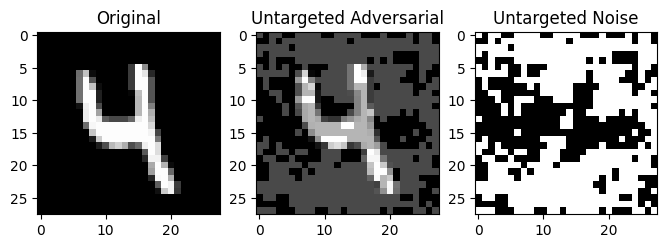

In [ ]:
noise = untargeted_adv_img - img
show_images(img, untargeted_adv_img, noise, type="Untargeted")

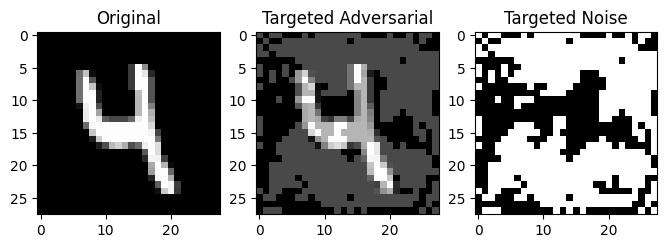

In [ ]:
noise = targeted_adv_img - img
show_images(img, targeted_adv_img, noise, type="Targeted")

In [ ]:
output = model(img)
_, predicted = torch.max(output.data, 1)
print(predicted)
x = torch.tensor(original_label).unsqueeze(0)
print(nn.CrossEntropyLoss()(output, x))

output = model(untargeted_adv_img)
_, predicted = torch.max(output.data, 1)
print(predicted)
x = torch.tensor(original_label).unsqueeze(0)
print(nn.CrossEntropyLoss()(output, x))

output = model(targeted_adv_img)
_, predicted = torch.max(output.data, 1)
print(predicted)
x = torch.tensor(target_label).unsqueeze(0)
print(nn.CrossEntropyLoss()(output, x))

tensor([4])
tensor(2.6226e-06, grad_fn=<NllLossBackward0>)
tensor([3])
tensor(54.3224, grad_fn=<NllLossBackward0>)
tensor([5])
tensor(0.0002, grad_fn=<NllLossBackward0>)


In [ ]:
def pgd_attack(img, eps, num_steps, original_label, target_label=None):

    adv_img = img.clone().detach().requires_grad_(True)
    original_label = torch.tensor(original_label).unsqueeze(0)
    if target_label is not None:
      target_label = torch.tensor(target_label).unsqueeze(0)

    for _ in range(num_steps):
        output = model(adv_img)
        if target_label is not None:
          loss = -nn.CrossEntropyLoss()(output, target_label)
        else:
          loss = nn.CrossEntropyLoss()(output, original_label)
        loss.backward()

        adv_img = adv_img.detach() + eps * adv_img.grad.sign()
        adv_img = torch.clamp(adv_img, 0, 1)  # Projection step
        adv_img.requires_grad = True
    return adv_img

untargeted_adv_img = pgd_attack(img.clone(), 0.2, 5, original_label)
target_label = (original_label + 1) % 10
targeted_adv_img = pgd_attack(img.clone(), 0.2, 5, original_label, target_label)

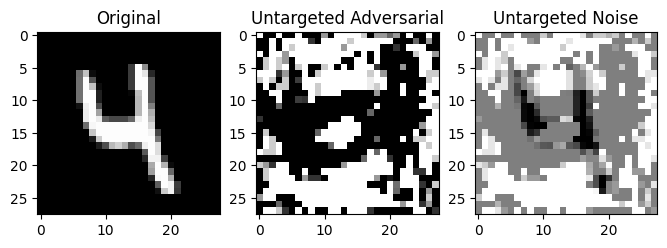

In [ ]:
noise = untargeted_adv_img - img
show_images(img, untargeted_adv_img, noise, type="Untargeted")

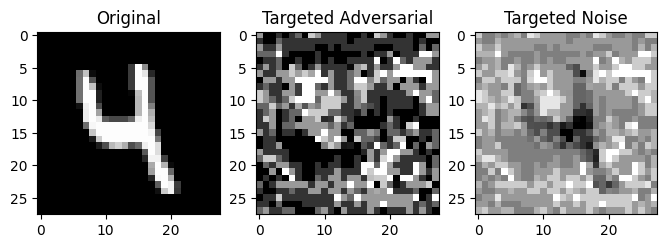

In [ ]:
noise = targeted_adv_img - img
show_images(img, targeted_adv_img, noise, type="Targeted")

In [ ]:
output = model(img)
_, predicted = torch.max(output.data, 1)
print(predicted)
x = torch.tensor(original_label).unsqueeze(0)
print(nn.CrossEntropyLoss()(output, x))

output = model(untargeted_adv_img)
_, predicted = torch.max(output.data, 1)
print(predicted)
x = torch.tensor(original_label).unsqueeze(0)
print(nn.CrossEntropyLoss()(output, x))

output = model(targeted_adv_img)
_, predicted = torch.max(output.data, 1)
print(predicted)
x = torch.tensor(target_label).unsqueeze(0)
print(nn.CrossEntropyLoss()(output, x))

tensor([4])
tensor(2.6226e-06, grad_fn=<NllLossBackward0>)
tensor([3])
tensor(232.5269, grad_fn=<NllLossBackward0>)
tensor([5])
tensor(0., grad_fn=<NllLossBackward0>)


**2. White Box Evasion Attack - Task 3**



In [ ]:
epsilon_values = [0.05, 0.15, 0.3]


**Fast Gradient Sign Method - Untargeted**

In [ ]:
test_len = len(test_data)
accuracies = []
for eps in epsilon_values:
  test_accuracy = 0
  for idx in range(test_len):
    img, original_label = test_data[idx]
    img = img.unsqueeze(0)
    adv_img = fgsm_attack(img.clone(), eps, original_label)
    with torch.no_grad():
        output = model(adv_img)
        predicted_label = output.argmax(dim=1)
    if predicted_label == original_label:
        test_accuracy += 1

  test_accuracy = test_accuracy / test_len * 100
  print(f"Epsilon: {eps}")
  print("Test accuracy on Fast Gradient Sign Method - Untargeted Adversarial images: {:.2f}%".format(test_accuracy))
  accuracies.append(test_accuracy)

Epsilon: 0.05
Test accuracy on Fast Gradient Sign Method - Untargeted Adversarial images: 26.17%
Epsilon: 0.15
Test accuracy on Fast Gradient Sign Method - Untargeted Adversarial images: 1.21%
Epsilon: 0.3
Test accuracy on Fast Gradient Sign Method - Untargeted Adversarial images: 0.14%


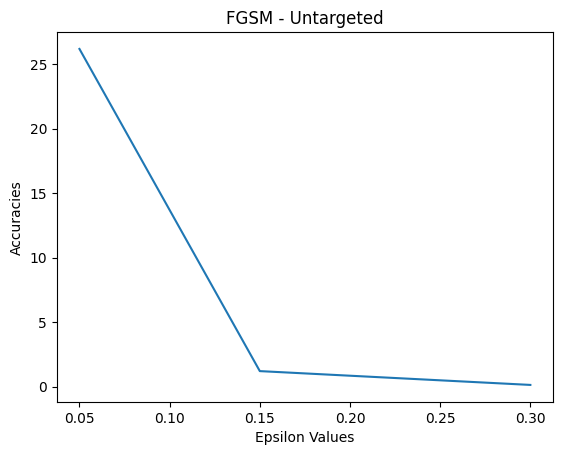

In [ ]:
fig, ax = plt.subplots()

ax.plot(epsilon_values, accuracies)

ax.set_xlabel('Epsilon Values')
ax.set_ylabel('Accuracies')
ax.set_title('FGSM - Untargeted')

plt.show()

**Fast Gradient Sign Method - Targeted**

In [ ]:
test_len = len(test_data)
accuracies = []
for eps in epsilon_values:
  test_accuracy = 0
  for idx in range(test_len):
    img, original_label = test_data[idx]
    img = img.unsqueeze(0)
    target_label = (original_label + 1)%10
    adv_img = fgsm_attack(img.clone(), eps, original_label, target_label)
    with torch.no_grad():
        output = model(adv_img)
        predicted_label = output.argmax(dim=1)
    if predicted_label == original_label:
        test_accuracy += 1

  test_accuracy = test_accuracy / test_len * 100
  print(f"Epsilon: {eps}")
  print("Test accuracy on Fast Gradient Sign Method - Targeted Adversarial images: {:.2f}%".format(test_accuracy))
  accuracies.append(test_accuracy)

Epsilon: 0.05
Test accuracy on Fast Gradient Sign Method - Targeted Adversarial images: 48.54%
Epsilon: 0.15
Test accuracy on Fast Gradient Sign Method - Targeted Adversarial images: 0.47%
Epsilon: 0.3
Test accuracy on Fast Gradient Sign Method - Targeted Adversarial images: 0.08%


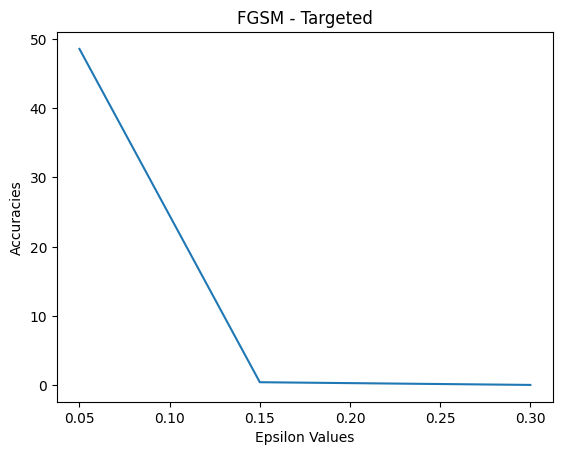

In [ ]:
fig, ax = plt.subplots()

ax.plot(epsilon_values, accuracies)

ax.set_xlabel('Epsilon Values')
ax.set_ylabel('Accuracies')
ax.set_title('FGSM - Targeted')

plt.show()

**Policy Gradient Descent - Untargeted** - Assuming 5 iterations

In [ ]:
test_len = len(test_data)
accuracies = []
for eps in epsilon_values:
  test_accuracy = 0
  for idx in range(test_len):
    img, original_label = test_data[idx]
    img = img.unsqueeze(0)
    adv_img = pgd_attack(img.clone(), eps, 5, original_label)
    with torch.no_grad():
        output = model(adv_img)
        predicted_label = output.argmax(dim=1)
    if predicted_label == original_label:
        test_accuracy += 1

  test_accuracy = test_accuracy / test_len * 100
  print(f"Epsilon: {eps}")
  print("Test accuracy on Policy Gradient Descent - Untargeted Adversarial images: {:.2f}%".format(test_accuracy))
  accuracies.append(test_accuracy)

Epsilon: 0.05
Test accuracy on Policy Gradient Descent - Untargeted Adversarial images: 0.05%
Epsilon: 0.15
Test accuracy on Policy Gradient Descent - Untargeted Adversarial images: 0.00%
Epsilon: 0.3
Test accuracy on Policy Gradient Descent - Untargeted Adversarial images: 0.00%


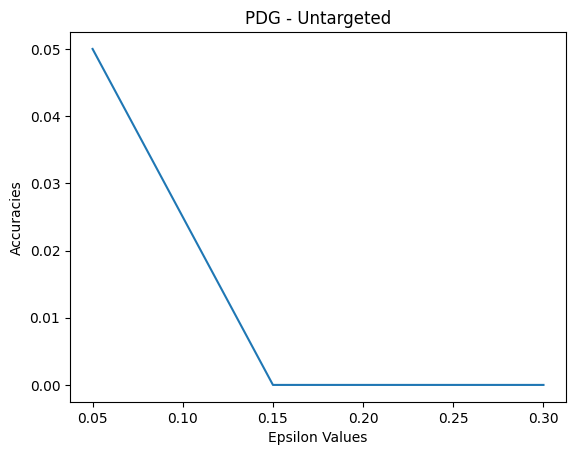

In [ ]:
fig, ax = plt.subplots()

ax.plot(epsilon_values, accuracies)

ax.set_xlabel('Epsilon Values')
ax.set_ylabel('Accuracies')
ax.set_title('PDG - Untargeted')

plt.show()

**Policy Gradient Descent - Targeted**  - Assuming 5 iterations

In [ ]:
test_len = len(test_data)
accuracies = []
for eps in epsilon_values:
  test_accuracy = 0
  for idx in range(test_len):
    img, original_label = test_data[idx]
    img = img.unsqueeze(0)

    target_label = (original_label + 1)%10
    adv_img = pgd_attack(img.clone(), eps, 5, original_label, target_label)

    with torch.no_grad():
        output = model(adv_img)
        predicted_label = output.argmax(dim=1)
    if predicted_label == original_label:
        test_accuracy += 1

  test_accuracy = test_accuracy / test_len * 100
  print(f"Epsilon: {eps}")
  print("Test accuracy on Policy Gradient Descent - Targeted Adversarial images: {:.2f}%".format(test_accuracy))
  accuracies.append(test_accuracy)

Epsilon: 0.05
Test accuracy on Policy Gradient Descent - Targeted Adversarial images: 0.45%
Epsilon: 0.15
Test accuracy on Policy Gradient Descent - Targeted Adversarial images: 0.01%
Epsilon: 0.3
Test accuracy on Policy Gradient Descent - Targeted Adversarial images: 0.20%


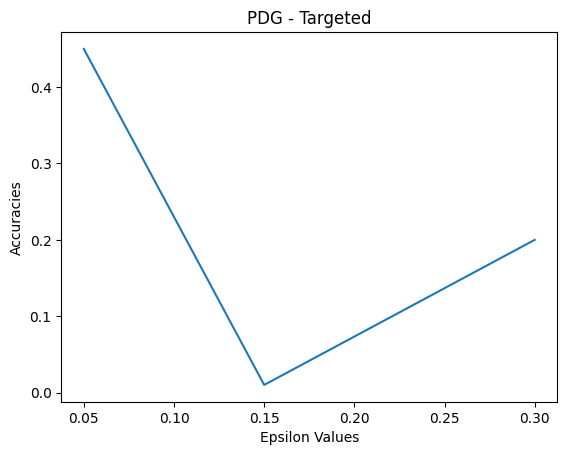

In [ ]:
fig, ax = plt.subplots()

ax.plot(epsilon_values, accuracies)

ax.set_xlabel('Epsilon Values')
ax.set_ylabel('Accuracies')
ax.set_title('PDG - Targeted')

plt.show()

**2. White Box Evasion Attack - Task 5 (Bonus)**

**Fast Gradient Sign Method - Untargeted**

In [ ]:
def fgsm_attack_batch(imgs, eps, original_labels, target_labels=None):
    imgs.requires_grad = True
    output = model(imgs)
    if target_labels is not None:
      loss = -nn.CrossEntropyLoss()(output, target_labels)
    else:
      loss = nn.CrossEntropyLoss()(output, original_labels)
    loss.backward()
    adv_imgs = imgs + eps * imgs.grad.sign()
    return adv_imgs

In [ ]:
for eps in [0.05, 0.15, 0.3]:
  model = MNISTModel()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

  model.train()

  for epoch in range(5):
      train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
      for images, labels in train_loader:
          adv_images = fgsm_attack_batch(images.clone(), eps, labels)
          optimizer.zero_grad()
          output = model(adv_images)
          loss = F.cross_entropy(output, labels)
          loss.backward()
          optimizer.step()

  model.eval()

  correct = 0
  total = 0

  with torch.no_grad():
      test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)
      for images, labels in test_loader:
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  accuracy = 100 * correct / total
  print(f"Epsilon: {eps}")
  print('Accuracy on test set:  {} %'.format(accuracy))

Epsilon: 0.05
Accuracy on test set:  98.34 %
Epsilon: 0.15
Accuracy on test set:  94.66 %
Epsilon: 0.3
Accuracy on test set:  50.96 %


**Fast Gradient Sign Method - Targeted**

In [ ]:
for eps in [0.05, 0.15, 0.3]:
  model = MNISTModel()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

  model.train()

  for epoch in range(5):
      train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
      for images, labels in train_loader:
          target_labels = (labels+1)%10
          adv_images = fgsm_attack_batch(images.clone(), eps, labels, target_labels)
          optimizer.zero_grad()
          output = model(adv_images)
          loss = F.cross_entropy(output, labels)
          loss.backward()
          optimizer.step()

  model.eval()

  correct = 0
  total = 0

  with torch.no_grad():
      test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)
      for images, labels in test_loader:
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  accuracy = 100 * correct / total
  print(f"Epsilon: {eps}")
  print('Accuracy on test set:  {} %'.format(accuracy))

Epsilon: 0.05
Accuracy on test set:  97.37 %
Epsilon: 0.15
Accuracy on test set:  92.26 %
Epsilon: 0.3
Accuracy on test set:  39.51 %


**Policy Gradient Descent - Untargeted** - Assuming 3 iterations

In [ ]:
def pgd_attack_batch(imgs, eps, num_steps, original_labels, target_labels=None):

    adv_imgs = imgs.clone().detach().requires_grad_(True)

    for _ in range(num_steps):
        output = model(adv_imgs)
        if target_labels is not None:
          loss = -nn.CrossEntropyLoss()(output, target_labels)
        else:
          loss = nn.CrossEntropyLoss()(output, original_labels)
        loss.backward()

        adv_imgs = adv_imgs.detach() + eps * adv_imgs.grad.sign()
        adv_imgs = torch.clamp(adv_imgs, 0, 1)  # Projection step
        adv_imgs.requires_grad = True
    return adv_imgs

In [ ]:
for eps in [0.05, 0.15, 0.3]:
  model = MNISTModel()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

  model.train()

  for epoch in range(5):
      train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
      for images, labels in train_loader:
          adv_images = pgd_attack_batch(images.clone(), eps, 3, labels)
          optimizer.zero_grad()
          output = model(adv_images)
          loss = F.cross_entropy(output, labels)
          loss.backward()
          optimizer.step()

  model.eval()

  correct = 0
  total = 0

  with torch.no_grad():
      test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)
      for images, labels in test_loader:
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  accuracy = 100 * correct / total
  print(f"Epsilon: {eps}")
  print('Accuracy on test set:  {} %'.format(accuracy))

Epsilon: 0.05
Accuracy on test set:  94.41 %
Epsilon: 0.15
Accuracy on test set:  11.35 %
Epsilon: 0.3
Accuracy on test set:  11.35 %


**Policy Gradient Descent - Targeted** - Assuming 3 iterations

In [ ]:
for eps in [0.05, 0.15, 0.3]:
  model = MNISTModel()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

  model.train()

  for epoch in range(5):
      train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
      for images, labels in train_loader:
          target_labels = (labels+1)%10
          adv_images = pgd_attack_batch(images.clone(), eps, 3, labels, target_labels)
          optimizer.zero_grad()
          output = model(adv_images)
          loss = F.cross_entropy(output, labels)
          loss.backward()
          optimizer.step()

  model.eval()

  correct = 0
  total = 0

  with torch.no_grad():
      test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)
      for images, labels in test_loader:
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  accuracy = 100 * correct / total
  print(f"Epsilon: {eps}")
  print('Accuracy on test set:  {} %'.format(accuracy))

Epsilon: 0.05
Accuracy on test set:  92.85 %
Epsilon: 0.15
Accuracy on test set:  13.22 %
Epsilon: 0.3
Accuracy on test set:  11.35 %
